In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from evaluation.metrics import intersection_over_union_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Read ground truth and predictions

In [2]:
root_path = Path('./data/datasets/test')

gt_df = pd.read_csv(root_path/'inference/ground_truth.csv').sort_values(by='image_id', ignore_index=True)
preds_df = pd.read_csv(root_path/'inference/predictions.csv').sort_values(by='image_id', ignore_index=True)
inter_gt = gt_df.loc[gt_df.image_id.isin(preds_df.image_id)].sort_values(by='image_id', ignore_index=True)

In [3]:
preds_df

,image_id,label,center_x,center_y,width,height,conf,category,scenery,img_width,img_height
0,10_custom,0,0.367083,0.145000,0.060833,0.092500,0.940430,custom,NaN,1200,800
1,12_custom,0,0.271973,0.244510,0.116211,0.079063,0.917969,custom,NaN,1024,683
2,13_custom,0,0.471924,0.584982,0.096191,0.145788,0.932617,custom,NaN,2048,1365
3,14_custom,0,0.520408,0.550095,0.097744,0.174618,0.944336,custom,NaN,1862,1048
4,16_custom,0,0.456250,0.218125,0.034167,0.051250,0.890137,custom,NaN,1200,800
...,...,...,...,...,...,...,...,...,...,...,...
520,v9_img022_bouncing,0,0.691016,0.555556,0.021094,0.038889,0.900879,bouncing,0.0,1280,720
521,v9_img023_bouncing,0,0.705078,0.505556,0.021094,0.038889,0.901855,bouncing,0.0,1280,720
522,v9_img024_bouncing,0,0.718750,0.468750,0.021875,0.040278,0.897461,bouncing,0.0,1280,720
523,v9_img025_bouncing,0,0.733203,0.445833,0.021094,0.038889,0.876465,bouncing,0.0,1280,720


In [4]:
gt_df

,image_id,label,center_x,center_y,width,height,conf,category,scenery,img_width,img_height
0,10_custom,0,0.366697,0.147030,0.056784,0.088207,NaN,custom,NaN,1200,800
1,11_custom,0,0.279548,0.225647,0.033562,0.066373,NaN,custom,NaN,1280,720
2,12_custom,0,0.277456,0.244561,0.114981,0.075036,NaN,custom,NaN,1024,683
3,13_custom,0,0.471659,0.583617,0.097191,0.142882,NaN,custom,NaN,2048,1365
4,14_custom,0,0.519974,0.541290,0.092996,0.165933,NaN,custom,NaN,1862,1048
...,...,...,...,...,...,...,...,...,...,...,...
560,v9_img022_bouncing,0,0.691668,0.553399,0.021104,0.039613,NaN,bouncing,0.0,1280,720
561,v9_img023_bouncing,0,0.705371,0.505462,0.021719,0.040065,NaN,bouncing,0.0,1280,720
562,v9_img024_bouncing,0,0.719439,0.469244,0.021930,0.039921,NaN,bouncing,0.0,1280,720
563,v9_img025_bouncing,0,0.733960,0.444452,0.019993,0.038611,NaN,bouncing,0.0,1280,720


## Metrics

**Intersection over union**

In [5]:
boxesA = inter_gt.iloc[:, 2:6].values
boxesB = preds_df.iloc[:, 2:6].values
width_height_matrix = preds_df.loc[:, ['img_width', 'img_height']].values
iou = intersection_over_union_matrix(boxesA, boxesB, width_height_matrix)

**Distance between (x_true, y_true) and (x_pred, y_pred), in pixel space**

In [6]:
xy_gt = inter_gt[['center_x', 'center_y']] * width_height_matrix
xy_pred = preds_df[['center_x', 'center_y']] * width_height_matrix
dist = ((xy_gt-xy_pred)**2).values.sum(axis=1)**(1/2)

**Accuracy**

In [7]:
acc_by_scenery = pd.DataFrame()
acc_by_scenery['acc'] = preds_df.groupby('scenery').count()['image_id']/gt_df.groupby('scenery').count()['image_id']
acc_by_scenery.T

scenery,0.0,1.0
acc,0.969349,0.890566


In [8]:
acc_by_category = pd.DataFrame()
acc_by_category['acc'] = preds_df.groupby('category').count()['image_id']/gt_df.groupby('category').count()['image_id']
acc_by_category.T

category,bouncing,custom,in_air,in_hands,near_basket
acc,0.983471,0.923077,0.990826,0.712766,0.938272


**Results dataframe**

In [9]:
results = pd.DataFrame(columns=['image_id', 'category', 'scenery', 'iou', 'dist', 'conf'], 
                       data=np.stack([preds_df.image_id.values, preds_df.category.values, 
                                      preds_df.scenery.values, iou, dist, preds_df.conf.values], axis=1))
results.iou = results.iou.astype('float32')
results.dist = results.dist.astype('float32')
results.conf = results.conf.astype('float32')
results

,image_id,category,scenery,iou,dist,conf
0,10_custom,custom,NaN,0.891547,1.688322,0.940430
1,12_custom,custom,NaN,0.866370,5.614566,0.917969
2,13_custom,custom,NaN,0.970340,1.940860,0.932617
3,14_custom,custom,NaN,0.859625,9.263069,0.944336
4,16_custom,custom,NaN,0.859108,2.292598,0.890137
...,...,...,...,...,...,...
520,v9_img022_bouncing,bouncing,0,0.849680,1.762590,0.900879
521,v9_img023_bouncing,bouncing,0,0.944628,0.381562,0.901855
522,v9_img024_bouncing,bouncing,0,0.919497,0.951512,0.897461
523,v9_img025_bouncing,bouncing,0,0.871294,1.388622,0.876465


**Intersection over union by scenery and category**

In [10]:
results.groupby('scenery')['iou'].describe()

,count,mean,std,min,25%,50%,75%,max
scenery,,,,,,,,
0.0,253.0,0.886647,0.052242,0.686386,0.857426,0.896365,0.926968,0.974923
1.0,236.0,0.861723,0.067466,0.569609,0.834903,0.878806,0.902656,0.973114


In [11]:
results.groupby('category')[['iou']].describe()

iou                                                    \
             count      mean       std       min       25%       50%   
category                                                               
bouncing     238.0  0.881248  0.052678  0.657349  0.847437  0.890600   
custom        36.0  0.891286  0.054995  0.709461  0.865921  0.893160   
in_air       108.0  0.897781  0.036656  0.774304  0.875970  0.898019   
in_hands      67.0  0.861731  0.063817  0.630086  0.830180  0.873319   
near_basket   76.0  0.832303  0.085433  0.569609  0.804818  0.851734   

                                 
                  75%       max  
category                         
bouncing     0.919751  0.974923  
custom       0.933451  0.970340  
in_air       0.921520  0.967752  
in_hands     0.904605  0.958373  
near_basket  0.890282  0.956163

**Pixel distance difference by scenery and category**

In [12]:
results.groupby('scenery')['dist'].describe()

,count,mean,std,min,25%,50%,75%,max
scenery,,,,,,,,
0.0,253.0,1.103664,0.703536,0.014849,0.536714,0.972310,1.481455,3.805833
1.0,236.0,1.300540,0.803576,0.046914,0.768695,1.127166,1.610118,5.141839


In [13]:
results.groupby('category')[['dist']].describe()

dist                                                    \
             count      mean       std       min       25%       50%   
category                                                               
bouncing     238.0  1.212753  0.722915  0.046914  0.632259  1.080595   
custom        36.0  4.624975  3.959428  0.213273  1.685703  3.819852   
in_air       108.0  0.779707  0.451014  0.014849  0.429399  0.713655   
in_hands      67.0  1.599608  0.888939  0.331736  1.027340  1.535221   
near_basket   76.0  1.396538  0.822062  0.124812  0.797465  1.222921   

                                  
                  75%        max  
category                          
bouncing     1.555713   5.141839  
custom       5.763215  18.772594  
in_air       1.040427   2.657845  
in_hands     2.028821   4.759685  
near_basket  1.844372   3.398253

Boxplots

array([<AxesSubplot:title={'center':'iou'}, xlabel='scenery'>,
       <AxesSubplot:title={'center':'dist'}, xlabel='scenery'>,
       <AxesSubplot:title={'center':'conf'}, xlabel='scenery'>],
      dtype=object)

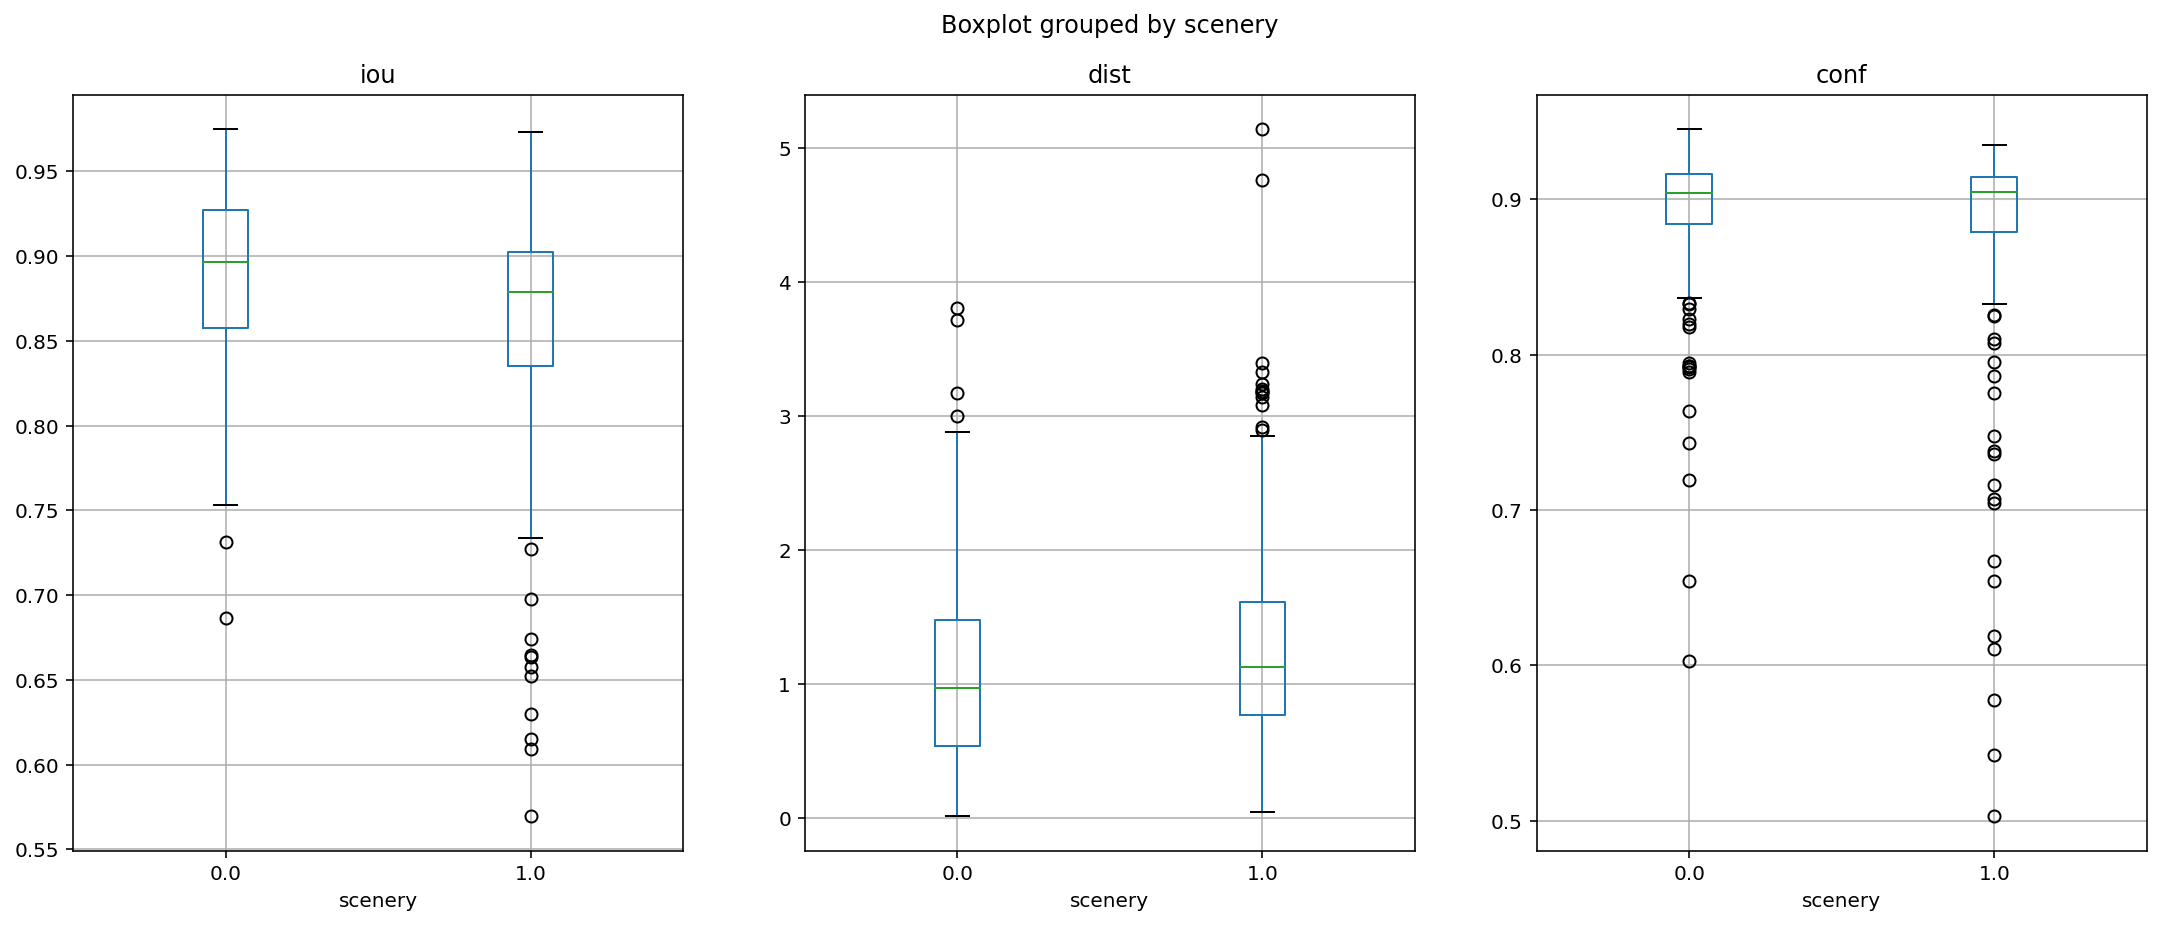

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(18, 7), sharex=False, sharey=False)
results.boxplot(column=['iou', 'dist', 'conf'], by='scenery', ax=ax)

array([<AxesSubplot:title={'center':'iou'}, xlabel='category'>,
       <AxesSubplot:title={'center':'dist'}, xlabel='category'>,
       <AxesSubplot:title={'center':'conf'}, xlabel='category'>],
      dtype=object)

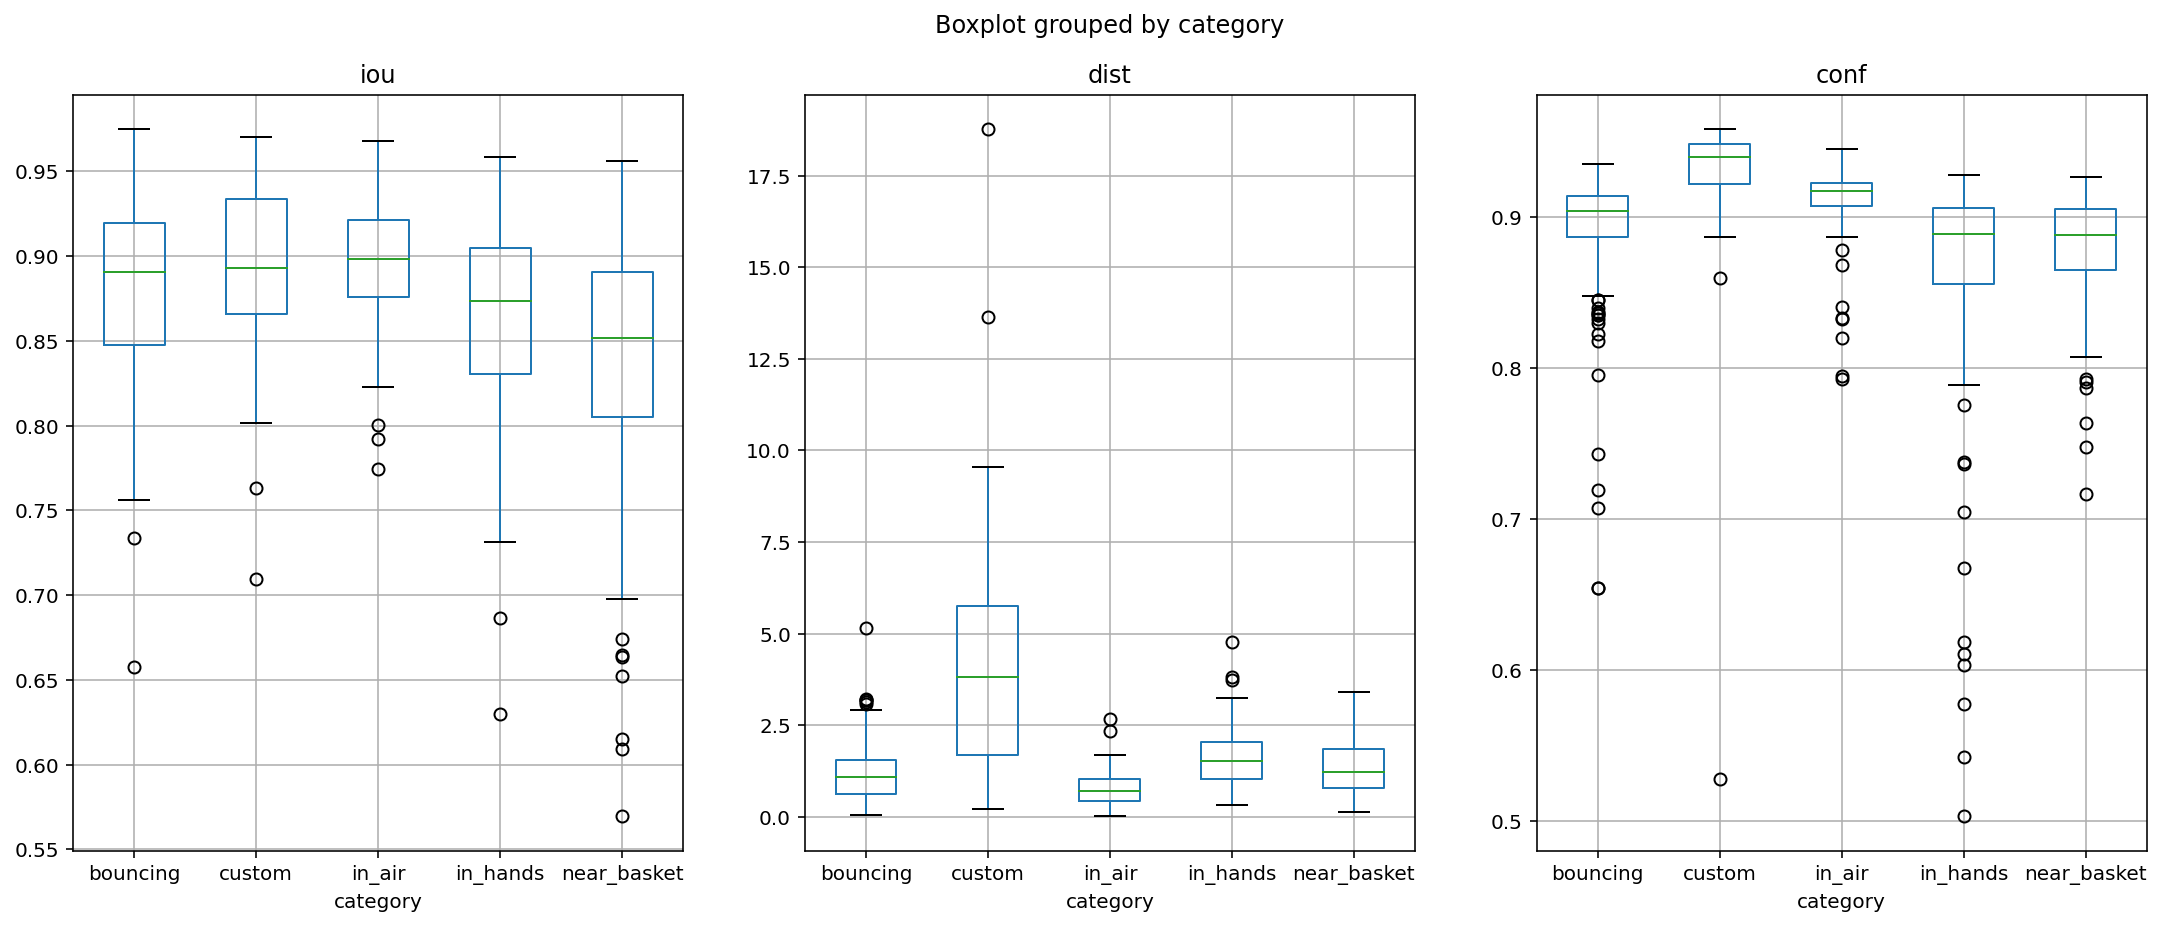

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(18, 7), sharex=False, sharey=False)
results.boxplot(column=['iou', 'dist', 'conf'], by='category', ax=ax)